In [1]:
# Import PyTorch
import torch
from torch import nn
import numpy as np

In [2]:
# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

In [3]:
# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Getting a Dataset

In [4]:
# setup training data
from torchvision import datasets

train_data = datasets.EMNIST(
        root = "data",
        split = "letters",
        train = True,
        download = True,
        transform = torchvision.transforms.Compose([
            lambda img : torchvision.transforms.functional.rotate(img,-90),
            lambda img : torchvision.transforms.functional.hflip(img),
            torchvision.transforms.ToTensor()
        ]),
        target_transform = None)


In [5]:
# setup testing datasets
test_data = datasets.EMNIST(
        root = "data",
        split = "letters",
        train = False,
        download = True,
        transform = torchvision.transforms.Compose([
            lambda img : torchvision.transforms.functional.rotate(img,-90),
            lambda img : torchvision.transforms.functional.hflip(img),
            torchvision.transforms.ToTensor()
        ]),
        target_transform = None)

In [6]:
class_names = train_data.classes
class_names

['N/A',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [8]:
train_data.targets

tensor([23,  7, 16,  ..., 13, 15, 19])

In [9]:
# # check the shape of our image
image,label = train_data[0]
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: w


# Visualizing images from data

 Image shape :torch.Size([1, 28, 28])


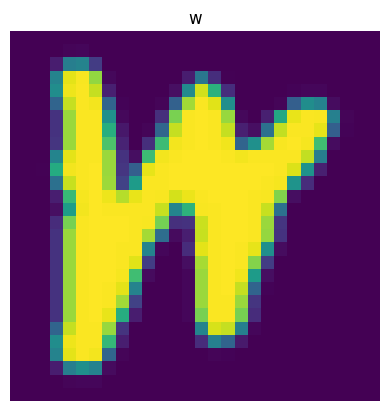

In [10]:
# Import matplotlib for visualization
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f" Image shape :{image.shape}")


        

plt.imshow(image.squeeze());    # matplotlib only need height and width    .......squeeze():= remove singular dimension that is greyscale
plt.title(class_names[label]);
plt.axis(False);

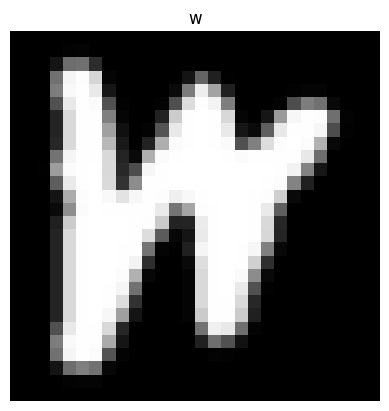

In [11]:
plt.imshow(image.squeeze(), cmap ="gray")
plt.title(class_names[label]);
plt.axis(False);

# Prepare for DataLoader

right now, our data is in the form of pytorch Datasets.<br>
Dataloader turns  our <b>dataset into a python iterable</b><br>
More specifically , we want to turn our data into <b>batches</b> (or mini-batches).<br><br>
Why would we do this ?<br>
1. It is more computational efficient , as in, your computing hardware may not be able to look (store in memory) at 60,000 images in one hit. so we break it down to 32 images at a time (batch size of 32)
2. It gives our neural network more chances to update its gradients per epoch.


In [12]:
## Prepare DataLoader

In [13]:
from torch.utils.data import DataLoader

#setup batch size hyperparameter 
BATCH_SIZE = 32

# turn datasets into iterables 

train_dataloader = DataLoader(
                    dataset = train_data,
                    batch_size = BATCH_SIZE,
                    shuffle = True)

test_dataloader = DataLoader(
                    dataset = test_data,
                    batch_size = BATCH_SIZE,
                    shuffle = False)


In [14]:
# checkout what we created 
print(f"Dataloader {train_dataloader , test_dataloader}")
print("length of train data:",len(train_data))
print("length of train_dataloader: ",len(train_dataloader))
print("length of test data:",len(test_data))
print("length of test_dataloader: ",len(test_dataloader))

Dataloader (<torch.utils.data.dataloader.DataLoader object at 0x000000C4518829D0>, <torch.utils.data.dataloader.DataLoader object at 0x000000C45187CF10>)
length of train data: 124800
length of train_dataloader:  3900
length of test data: 20800
length of test_dataloader:  650


In [15]:
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size:torch.Size([1, 28, 28])
label:1,label size:torch.Size([])


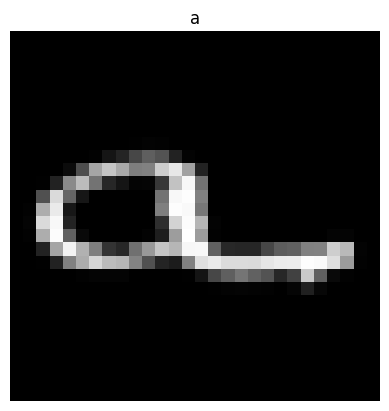

In [16]:
# show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img , label = train_features_batch[random_idx] , train_labels_batch[random_idx]

plt.imshow(img.squeeze(),cmap = "gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size:{img.shape}")
print(f"label:{label},label size:{label.shape}")

In [17]:
import requests
from pathlib import Path

# download helper functions from learn pytorch repo 

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists , skipping download ...")
else:
    print("downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")# when dealing with github we need to pass raw link 
    with open("helper_functions.py","wb") as f:
        f.write(request.content)
        

helper_functions.py already exists , skipping download ...


### Creating a function to time our experiments

Machine learning is very experimental .

Two of the main things you'll often want to track are:
1. Models performance (loss and accuracy values etc)
2. How fast it runs 

In [18]:
from timeit import default_timer as timer 

def print_train_time(start: float, end: float, device: torch.device = None):
    '''Prints difference between start and end time.'''
    total_time = end - start
    print(f'train time on {device} : {total_time:.3f} seconds')
    return total_time

# Creating a training loop and training  a model on batches of data 

1. Loop through epochs .
2. Loop through training batches , perform training steps, calculate the train loss *per batch*
3. Loop through testing batches , perform testing steps , calculate the test loss *per batch*
4. Print out what's happening .
5. Time it all 

In [19]:
def eval_model(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn):
    
    '''Returns a dictionary containing the results of model predicting on data_loader.'''
    loss, acc = 0,0
    
    model.eval()
    with torch.inference_mode():
        for x , y in tqdm(data_loader) :
            # Make predictions
            y_pred = model(x)
            
            # Accumulate the loss and accumulate values per batch 
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true = y ,y_pred = y_pred.argmax(dim = 1))
        
        # scale loss and acc to find the average loss/acc per batch
        
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name:":model.__class__.__name__ , # only works when model was created with a class 
           "model_loss":loss.item(),
            "model_acc":acc
           }

In [20]:
#functionizing training loop

def train_step(model: torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy_fn
              ):
    '''performs  a training with model trying to learn on data_loader'''
    train_loss , train_acc = 0,0
    
    for batch , (x,y) in enumerate(data_loader):
        model.train()
        
        # 1. Forward pass 
        y_pred = model(x)
        
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred,y)
        train_loss +=loss # cumulate the train loss for every batch
        
        # 3. Caluculate accuracy
        train_acc += accuracy_fn(y_true = y , y_pred = y_pred.argmax(dim=1))
        
        # 3. optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward 
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
    
        #print out whats happening 
        if batch % 400 == 0:
            print(f'looked at {batch * len(x)}/{len(data_loader.dataset)} samples .')
    
    # Divide total train_loss by length of train dataloader 
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"train loss: {train_loss:.5f} | train accuracy : {train_acc:.2f}% \n")

In [21]:
def test_step(model: torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy_fn
              ):
    '''performs a testing with model trying to learn on data_loader'''
    test_loss , test_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for x_test,y_test in test_dataloader :
            # 1. forward pass
            test_pred = model(x_test)
            
            # 2. test loss 
            test_loss += loss_fn(test_pred,y_test)
            
            # 3. Caluculate accuracy
            test_acc += accuracy_fn(y_true = y_test , y_pred = test_pred.argmax(dim=1))       #argmax to get index pf which weight in labels is maximum 
            
        # calculate the test loss average per batch
        test_loss /= len(data_loader)
        
        # calculate the test Accuracy average per batch 
        test_acc /= len(data_loader)
        
        print(f"Test Loss : {test_loss:.4f} , test acc: {test_acc:.4f}%\n")

# Building a Convolutional Neural Network (CNN)

CNN's are also known ConvoNets.
CNN's are known for their capabilties to find patterns in visual data .

In [22]:
##cnn explainer

In [23]:
# Create a concolutional neural network 

class CNNModel(nn.Module):

    def __init__( self, input_shape:int,hidden_units:int,output_shape:int):
        
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape ,
                      out_channels = hidden_units,
                      kernel_size = 3 ,
                      stride=1 ,
                      padding = 1) ,
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units ,
                      out_channels = hidden_units,
                      kernel_size = 3 ,
                      stride=1 ,
                      padding = 1) ,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
            
        ) # values we can set ourselves in our NN's are called hyperparameters 
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units ,
                      out_channels = hidden_units,
                      kernel_size = 3 ,
                      stride=1 ,
                      padding = 1) ,
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units ,
                      out_channels = hidden_units,
                      kernel_size = 3 ,
                      stride=1 ,
                      padding = 1) ,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
            
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, #trick to calculate this
                     out_features=output_shape)
        )
        
    def forward(self,x):
        x = self.conv_block_1(x)
#         print(x.shape)
        x = self.conv_block_2(x)
#         print(x.shape)
        x = self.classifier(x)
        
        return x

In [24]:
model_2 = CNNModel(input_shape = 1,  #color units 
                   hidden_units = 27,
                   output_shape = len(class_names)
                  )

model_2

CNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1323, out_features=27, bias=True)
  )
)

# Setup loss function , optimizer for cnn model

In [25]:
# setup loss function 
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(),
                           lr=0.1)

In [26]:
# model_2.state_dict()

## training and testing cnn model

In [ ]:
# measure time
from tqdm.auto import tqdm
from timeit import default_timer as timer 
train_time_start = timer()


epochs = 3

for epoch in tqdm(range(epochs)):
    
    train_step(model = model_2,
              data_loader=train_dataloader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               accuracy_fn=accuracy_fn)
    
    test_step(model = model_2,
              data_loader=test_dataloader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               accuracy_fn=accuracy_fn)
    
train_time_end = timer()
total_trian_time = print_train_time(start = train_time_start , end = train_time_end,device="cpu")

  0%|          | 0/3 [00:00<?, ?it/s]

looked at 0/124800 samples .
looked at 12800/124800 samples .
looked at 25600/124800 samples .
looked at 38400/124800 samples .
looked at 51200/124800 samples .
looked at 64000/124800 samples .
looked at 76800/124800 samples .
looked at 89600/124800 samples .
looked at 102400/124800 samples .
looked at 115200/124800 samples .
train loss: 0.52217 | train accuracy : 83.94% 

Test Loss : 0.2999 , test acc: 90.4135%

looked at 0/124800 samples .
looked at 12800/124800 samples .
looked at 25600/124800 samples .
looked at 38400/124800 samples .
looked at 51200/124800 samples .
looked at 64000/124800 samples .
looked at 76800/124800 samples .


In [ ]:
print(f" Train time in minutes : {total_trian_time//60} min.")

In [ ]:
# get model_2 results 

model_2_results = eval_model(
    model = model_2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn   
)

model_2_results

In [ ]:
def make_predictions( model:torch.nn.Module,
                    data: list,
                    device: torch.device = "cpu"):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data :
            # prepare the sample (add a batch dimension and pass to target device )
            sample = torch.unsqueeze(sample,dim=0)
            
            # forward pass (model outputs raw logits)
            pred_logit = model(sample)
            
            # get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            # get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob)
            
        #stack the pred_probs to turn list into a tensor 
        return torch.stack(pred_probs)
    

In [ ]:
model_2 = CNNModel(input_shape = 1,  #color units 
                   hidden_units = 27,
                   output_shape = len(class_names)
                  )


In [ ]:
PATH = 'models/CNN_model_letter_detection.pth'
model_2.load_state_dict(torch.load(PATH))
model_2.eval()

In [ ]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample , label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
# # view the first sample shape 
# test_samples[0].shape

# make predictions
pred_probs = make_predictions(model = model_2,
                             data = test_samples)

# # view first two prediction probabilites 
# pred_probs[:2]

# convert prediction probabilities to labels 
pred_classes = pred_probs.argmax(dim=1)


# Plot predictiions 
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    # create subplot 
    plt.subplot(nrows,ncols,i+1)
    
    # plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")
    
    # Find the prediction (in text form)
    pred_label = class_names[pred_classes[i]]
    
    # get the truth label (in text form )
    truth_label = class_names[test_labels[i]]
    
    # create a title for the plot 
    title_text = f"pred : {pred_label} | Truth: { truth_label}"
    
    # check for equality between pred and truth  and change color of title text
    if pred_label == truth_label :
        plt.title(title_text, fontsize = 10, c="g") # green text if prediction same as truth 
    else:
        plt.title(title_text, fontsize = 10,c='r')
    

# making a confusion matrix for further prediction evaluation 

In [ ]:
# import tqdm.auto
from tqdm.auto import tqdm

# 1. make predictions with trained model
y_preds = []
model_2.eval()

with torch.inference_mode():
    for x,y in tqdm(test_dataloader , desc ="Making predictions ..."):
        
        # do the forward pass
        y_logit = model_2(x)
        
        # turn predictions from logits -> prediction probabilties -> prediction labels
        y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
        
        #put prediction on cpu for evaluation
        y_preds.append(y_pred)
        
# concatenate list of predictions into a tensor

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor
        

In [ ]:
import torchmetrics, mlxtend
mlxtend.__version__

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import numpy
# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes = len(class_names),task='multiclass')
confmat_tensor = confmat(preds = y_pred_tensor , target = test_data.targets)

# 3. plot the confusion matrix 
fig , ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),   #matplotlib likes working with numpy 
                                class_names = class_names,
                                figsize=(15,15))

In [ ]:
confmat_tensor

# Save and load best performing model

In [ ]:
from pathlib import Path

# create model directory path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True ,
                exist_ok = True)

# create model save 
MODEL_NAME = "CNN_model_letter_detection.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

In [ ]:
# save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(),f = MODEL_SAVE_PATH)

In [ ]:
model_2.state_dict()

In [ ]:
import matplotlib.pyplot as plt
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)
    if(len(im_data.shape)==2):
        height , width = im_data.shape
    else:
        height , width , depth = im_data.shape
    
    # what size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi) , height / float(dpi)
    
    # create a figure of the right size with one axes that takes up the ull figure 
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0,0,1,1])
    
    # Hide spines, ticks etc.
    ax.axis('off')
    
    #display the image
    ax.imshow(im_data , cmap="gray")
    plt.show()

In [ ]:
import cv2
image_url = "image_for_practice_.jpg"


def create_bounding_boxes(image_url):
    image = cv2.imread(image_url)
    
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#     print("gray")
#     cv2.imwrite("bbox_gray.jpg",gray)
#     display("bbox_gray.jpg")
    blur = cv2.GaussianBlur(gray,(7,7),0)        #object,size of blurring,
#     print("blur")
#     cv2.imwrite("bbox_blur.jpg",blur)
#     display("bbox_blur.jpg")
    thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]       # blurr object , range ,
#     print("thresh")
#     cv2.imwrite("bbox_thresh.jpg",thresh)
#     display("bbox_thresh.jpg")
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,13))
    
    dilate = cv2.dilate(thresh, kernel , iterations=1)
#     print("dilate")
#     cv2.imwrite("bbox_dilate.jpg",dilate)
#     display("bbox_dilate.jpg")
#     cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts)==2 else cnts[1]
    
    cnts = sorted(cnts, key=lambda x:cv2.boundingRect(x)[0])
    i=1
    word_bounding_boxes = []
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if h<30:
            cv2.rectangle(image,(x,y),(x+w,y+h),(36,255,12),1)
            word_bounding_boxes.append((x,y,w,h))
            
            # Crop the region from the image
            cropped_image = image[y:y+h, x:x+w]           
            
            print(f"bbox{i}")
            
            
            # Save the cropped image
            cv2.imwrite(f'cropped_image{i}.jpg', cropped_image)
            display(f'cropped_image{i}.jpg')
            
            i+=1
#             cv2.imwrite("bbox_image.jpg",image)
#             display("bbox_image.jpg")

In [ ]:
create_bounding_boxes(image_url)